In [449]:
import numpy
import matplotlib.pyplot as pyplot
from sklearn.naive_bayes import GaussianNB;
from sklearn.datasets import load_wine
samples, labels = load_wine(return_X_y=True)

In [450]:
samples = numpy.transpose(samples)

m = numpy.mean(samples,1)
samplesc = samples - numpy.reshape(m,(13,1))

std = numpy.std(samples,1)
samplesn = samples - numpy.reshape(m,(13,1))

for i in range(13):
    samplesn[i,:] = samplesc[i,:]/std[i]

# PCA of Centered Data

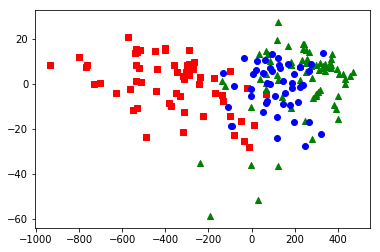

In [451]:
U,S,Vh = numpy.linalg.svd(samplesc)
U2 = U[:,0:2]
featc = numpy.matmul(numpy.transpose(U2),samplesc)


l0 = []
l1 = []
l2 = []

for i, l in enumerate(labels):
    if l == 0:
        l0.append(featc[:,i])
    if l == 1:
        l1.append(featc[:,i])
    if l == 2:
        l2.append(featc[:,i])
        
l0 = numpy.transpose(l0)
l1 = numpy.transpose(l1)
l2 = numpy.transpose(l2)
points = [l0, l1, l2]

c = ["red", "green", "blue"]
mk = ["s", "^", "o"]

f = pyplot.figure()
for i in range(3):
    x,y = points[i]
    pyplot.scatter(x, y, c = c[i], marker=mk[i])

# PCA of Normalized Data

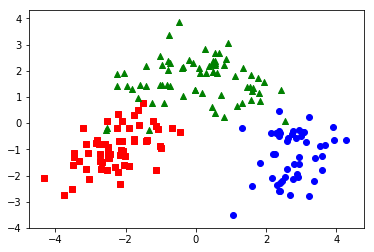

In [452]:
U,S,Vh = numpy.linalg.svd(samplesn)
U2 = U[:,0:2]
featn = numpy.matmul(numpy.transpose(U2),samplesn)


l0 = []
l1 = []
l2 = []

for i, l in enumerate(labels):
    if l == 0:
        l0.append(featn[:,i])
    if l == 1:
        l1.append(featn[:,i])
    if l == 2:
        l2.append(featn[:,i])
        
l0 = numpy.transpose(l0)
l1 = numpy.transpose(l1)
l2 = numpy.transpose(l2)
points = [l0, l1, l2]

c = ["red", "green", "blue"]
mk = ["s", "^", "o"]

f = pyplot.figure()
for i in range(3):
    x,y = points[i]
    pyplot.scatter(x, y, c = c[i], marker=mk[i])

Based on the graphs above, the normalized and centered data set would lead to a better classification performance. In the PCA of the normalized and centered data, the labels are much closer grouped and more seperated from the other labels.

# Naive Bayes Classification

In [464]:
#Training fcn gets passed a 3x(Training Data) where rows 0,1 are features and row 2 is the label
def train(A):
    l0 = []
    l1 = []
    l2 = []
    
    for i in range(A.shape[1]):
        l = A[2,i]
        if l == 0:
            l0.append(A[0:2,i])
        if l == 1:
            l1.append(A[0:2,i])
        if l == 2:
            l2.append(A[0:2,i])
    
    l0 = numpy.transpose(l0)
    l1 = numpy.transpose(l1)
    l2 = numpy.transpose(l2)
    
    mean0 = numpy.mean(l0,1)
    mean1 = numpy.mean(l1,1)
    mean2 = numpy.mean(l2,1)
    mean = numpy.stack((mean0,mean1,mean2), axis=1)
    
    std0 = numpy.std(l0,1)
    std1 = numpy.std(l1,1)
    std2 = numpy.std(l2,1)
    stdt = numpy.stack((std0,std1,std2), axis=1)

    return mean, stdt

#Gaussian PDF
def GaussPDF(x, mean, std) :
    return 1/numpy.sqrt(2*numpy.pi*std**2) * numpy.exp(-(x-mean)**2/(2*std**2));


#Test fcn gets passed a 2x(Test Data). Mean and stdt should be 2x3 matrices for the mean and std of each feature per label
def test(A, mean, stdt):
    testl = []
    for i in range(numpy.shape(A)[1]):
        prob0 = GaussPDF(A[0,i],mean[0,0], stdt[0,0])*GaussPDF(A[1,i],mean[1,0], stdt[1,0])

        prob1 = GaussPDF(A[0,i],mean[0,1], stdt[0,1])*GaussPDF(A[1,i],mean[1,1], stdt[1,1])
        
        prob2 = GaussPDF(A[0,i],mean[0,2], stdt[0,2])*GaussPDF(A[1,i],mean[1,2], stdt[1,2])
        
        
        if max([prob0, prob1, prob2]) == prob0:
            testl.append(0)
        if max([prob0, prob1, prob2]) == prob1:
            testl.append(1)
        if max([prob0, prob1, prob2]) == prob2:
            testl.append(2)
    
    return testl


def KCV5(A, sk = False):
    acc = []
    for i in range(5):
        if i == 0:
            testing = A[:,0:36]
            training = A[:,36:178]
        if i == 1:
            testing = A[:,36:72]
            training = numpy.concatenate((A[:,0:36],A[:,72:178]), axis=1)
        if i == 2:
            testing = A[:,72:108]
            training = numpy.concatenate((A[:,0:72],A[:,108:178]), axis=1)
        if i == 3:
            testing = A[:,108:143]
            training = numpy.concatenate((A[:,0:108],A[:,143:178]), axis=1)
        if i == 4:
            testing = A[:,143:178]
            training = A[:,0:143]
            
        if sk == False:
            mean, std = train(training)

            predlabels = test(testing[0:2,:], mean, std)
        if sk == True:
            g = GaussianNB();
            
            g.fit(training[0:2,:].T, training[2,:].T)
            predlabels = g.predict(testing[0:2,:].T)
            
        numcor = 0
        for j, l in enumerate(predlabels):
            if l == testing[2,j]:
                numcor += 1
        temp = numcor/numpy.shape(testing)[1]

        acc.append(temp)
        
            
    return acc
                
        

# Case I, II, and III

In [470]:
featc2 = numpy.vstack((featc,numpy.reshape(labels,[1,178])))
featn2 = numpy.vstack((featn,numpy.reshape(labels,[1,178])))

featc2 = numpy.random.permutation(featc2.T).T
featn2 = numpy.random.permutation(featn2.T).T

#Case 1
plsc = KCV5(featc2)
print("Case I: Classification of the Centered Data Using my Naive Bayes Classifier.")
print("Accuracy of each K-CV test:",plsc)
print("Mean:",numpy.mean(plsc))
print("Variance:",numpy.std(plsc))

print()
print("Case II: Classification of the Centered and Normalized Data Using my Naive Bayes Classifier.")
#Case 2
plsn1 = KCV5(featn2)
print("Accuracy of each K-CV test:",plsn1)
print("Mean:",numpy.mean(plsn1))
print("Variance:",numpy.var(plsn1))

print()
print("Case III: Classification of the Centered and Normalized Data Using sklearn's Naive Bayes Classifier.")
#Case 3
plsn2 = KCV5(featn2, sk = True)
print("Accuracy of each K-CV test:",plsn2)
print("Mean:",numpy.mean(plsn2))
print("Variance:",numpy.var(plsn2))


Case I: Classification of the Centered Data Using my Naive Bayes Classifier.
Accuracy of each K-CV test: [0.8333333333333334, 0.75, 0.75, 0.7142857142857143, 0.7428571428571429]
Mean: 0.7580952380952382
Variance: 0.039858024681603016

Case II: Classification of the Centered and Normalized Data Using my Naive Bayes Classifier.
Accuracy of each K-CV test: [0.9444444444444444, 1.0, 0.9444444444444444, 0.9714285714285714, 1.0]
Mean: 0.9720634920634922
Variance: 0.0006173847316704466

Case III: Classification of the Centered and Normalized Data Using sklearn's Naive Bayes Classifier.
Accuracy of each K-CV test: [0.9444444444444444, 0.9722222222222222, 0.9444444444444444, 0.9714285714285714, 0.9714285714285714]
Mean: 0.9607936507936508
Variance: 0.00017828168304358797


As predicted earlier, the classifier I made has a higher accuracy when working with centered and normalized data as opposed to just centered. The mean accuracy is higher and the variance is lower when classifying centered and normalized data. So its obvious than when attempting to classify data you should center and normalize it for the best resusts. As for my implementation of the classifier, I achieved a simimlar accuracy as the sklearn implementation. Since sklearn's functions are well trusted, it is safe to say that my algorithm is effective in implementing a Naive Bayes Classifier.